<a href="https://colab.research.google.com/github/FinnHendricks/YOLO_ConeDetection/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FinnHendricks/YOLO_ConeDetection/blob/main/train.ipynb)


## Steps:
- basic CNN architecture / class - ok
- input pipeline - ok
- visualisation - ok
- IoU - ok
- Loss function
- non maxima suppression
- Train/optimizer
- training
- better architecture, batch_norm
- augmentation

- result: sigmoid on center + exponent of w+h

## General steps:
- Yolo on cones 
- introduce different scales
- Yolo on COCO
- introduce anchor boxes
- CARLA data
- Yolo on Carla

## yolo-format (called label(s) in this notebook:
- each image has its own label file with the same file name
- each cone of an image is described by one line
- Format in txt files: class, x_center, y_center, width_bbox, height_bbox
- Format used in this notebook: [objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6]

- 0 blue
- 1 yellow
- 2 orange-small
- 3 orange-big (shown in red)
- 4 yellow-big (shown in white)
- 5 green
- 6 lying

## YOLO-Output (called y / y_pred / y_true in this notebook:

Per S x S grid cell, e.g. 8x8:
x,y, height, width, objectness, prob per class

--> 8x8x(4+1+7) = 8x8x12 = 768 output neurons


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import os
import cv2

import matplotlib.pyplot as plt

print(tf.config.list_physical_devices())
print(tf.__version__)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.6.0


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Sep 25 10:26:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!gdown https://drive.google.com/uc?id=1OBJucC4oklE9-k4mZ5nQheoor6R548Tu


Downloading...
From: https://drive.google.com/uc?id=1OBJucC4oklE9-k4mZ5nQheoor6R548Tu
To: /content/cones_multi_class_partial.zip
209MB [00:04, 42.1MB/s]


In [5]:
%%capture
!unzip -u "/content/cones_multi_class_partial.zip" -d "/content/";

In [6]:

# download helper file
!gdown https://drive.google.com/uc?id=1OM2CgpOrturcsnqiOmMydwXAghpeveC-

from helper_yolo import iou_width_height as iou
from helper_yolo import non_max_suppression as nms


Downloading...
From: https://drive.google.com/uc?id=1OM2CgpOrturcsnqiOmMydwXAghpeveC-
To: /content/helper_yolo.py
100% 18.9k/18.9k [00:00<00:00, 15.4MB/s]


In [7]:

img_width = 512#800
img_height = 512#320
img_channels = 3
grid_X = 8
grid_Y = 8
batch_size = 16
epochs = 5
train_size = 128 #20_000
num_classes = 7  # blue, yellow, orange_small, o_big, yellow, green, lying
initial_learning_rate = 0.01
#final_learning_rate = 0.001
#learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1/epochs)
steps_per_epoch = int(train_size/batch_size)


In [28]:
# convert the label given in the csv files to a matrix that can be used as y

def convert_label_to_y(label, file):
    object_class, x_center, y_center, width_bbox, height_bbox = list(map(float, label))

    # find relevant grid cell for predicting the object
    i, j = int(y_center * grid_Y), int(x_center * grid_X) # i row, j column 

    assert i < grid_Y, "center must be within the image" + str(file.name)
    assert j < grid_X, "center must be within the image" + str(file.name)

    x_center_bbox = x_center * grid_X - j  # find center relative to cell; 0...1
    y_center_bbox = y_center * grid_Y - i

    width_bbox *= grid_X  # scale box size, that 1 equals the grid size -> range of object size makes more sense
    height_bbox *= grid_Y

    c0, c1, c2, c3, c4, c5, c6 = tf.one_hot(tf.range(7), 7)[int(object_class)] # class of the cone
    # objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6
    y = np.zeros((grid_X, grid_Y, num_classes+5 ))
    y[i, j] = [1.0, x_center_bbox, y_center_bbox, width_bbox, height_bbox, c0, c1, c2, c3, c4, c5, c6]
    return y

In [30]:
# find labels and image paths - each image has its own txt file and each line of the file is for one image
directory_train = '/content/cones_multi_class_partial/train'
directory_test = '/content/cones_multi_class_partial/test/'

def read_data(path):

    jpg_paths = []
    n_samples = 0
    for file in os.listdir(path):
        if file.endswith(".txt"):
            n_samples += 1

    sample_ctr = 0
    y = np.zeros((n_samples, grid_X, grid_Y, num_classes+5 ))
    for file in os.listdir(path):
        if file.endswith(".txt"):
            with open(os.path.join(path, file), "r") as file:
                for label in file:
                    label = label.strip().split(" ")
                    y[sample_ctr] += convert_label_to_y(label, file) 
            
            #find the corresponding image path
            jpg_path = file.name.strip("txt")+"jpg"
            jpg_paths.append(jpg_path)
            sample_ctr += 1
            
    return jpg_paths, y
            
jpg_paths_train, y_train = read_data(directory_train)
jpg_paths_test, y_test = read_data(directory_test)
print(y_train.shape[0], " train images found.")
print(y_test.shape[0], " test images found.")



128  train images found.
32  test images found.


In [ ]:
# input data

ds_train = tf.data.Dataset.from_tensor_slices((jpg_paths_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((jpg_paths_test, y_test))

def read_image(image_file, y):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)#, dtype=tf.float32)
    return image, y

def resize(image, y):
    image = tf.image.resize(image, [img_height, img_width], method=tf.image.ResizeMethod.BILINEAR,preserve_aspect_ratio=False)
    image = image / 255. # rescale
    return image, y


#ds_train = ds_train.map(read_image).map(resize_and_crop).map(augment).batch(batch_size)
ds_train = ds_train.map(read_image).map(resize).shuffle(train_size).batch(batch_size).prefetch(2)
ds_test = ds_test.map(read_image).map(resize).batch(batch_size)




In [36]:
y_test[0]

array([[[0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
         0.      , 0.      , 0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      

In [40]:
s = y_test[0]
np.where(s[:,:,0]>=0.3)
#s[s[:,:,0]==1]

(array([2, 2]), array([2, 5]))

In [ ]:
def visualize(image):
    fig = plt.figure(figsize=(10,10))
    plt.title('Image')
    plt.imshow(image)


def draw_bounding_box(image, y):
    image = image.numpy()
    h, w, _ = image.shape   
    relevant_grids = np.where(s[:,:,0]>=0.3)  # compresses y into an array keeping only objects with objectness > 0.3 
    for grid in relevant_grids:
        objectness, x_center_bbox, y_center_bbox, width_bbox, height_bbox, c0, c1, c2, c3, c4, c5, c6 = y[grid]
        #blue, yellow, orange, orange-big, yellow-big, green, lying
        object_class = np.argmax(cone[5:])

        #Todo: class when not 0 / 1
        color = np.array([0, 0, 255])*cone[5] + \
            np.array([255, 255, 0])*cone[6] + \
            np.array([255, 165, 0])*cone[7] + \
            np.array([255, 0  , 0])*cone[8] + \
            np.array([255, 255, 255])*cone[9] + \
            np.array([0  , 255, 0])*cone[10] + \
            np.array([0  , 0  , 0])*cone[11]
        color = color * cone[0]  # adjust brightness based on objectness

        color = tf.make_tensor_proto(color)
        color = tf.make_ndarray(color).astype(int).tolist()
    
        x_center = float(cone[1])*w
        y_center = float(cone[2])*h
        box_width = float(cone[3])*w
        box_height = float(cone[4])*h
        
        x_min = int(x_center - box_width/2)
        x_max = int(x_center + box_width/2)
        y_min = int(y_center - box_height/2)
        y_max = int(y_center + box_height/2)
        
        image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2) 
        #print( (x_min, y_min), (x_max, y_max), color)

    return image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


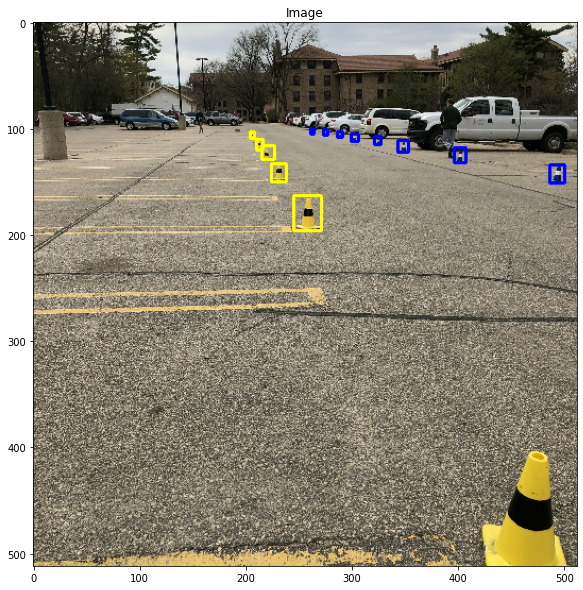

In [ ]:
for images, y in ds_test:
    #print(images.shape)
    i = np.random.randint(0, batch_size)
    image = draw_bounding_box(images[i], y[i])
    visualize(image)
    break

In [ ]:
def label2box(cone):
    x_center = float(cone[1])*img_width
    y_center = float(cone[2])*img_height
    box_width = float(cone[3])*img_width
    box_height = float(cone[4])*img_height

    x_min = int(x_center - box_width/2)
    x_max = int(x_center + box_width/2)
    y_min = int(y_center - box_height/2)
    y_max = int(y_center + box_height/2)
    return (x_min, x_max, y_min, y_max)


# http://datahacker.rs/tensorflow2-0-yolov3/
def interval_overlap(interval_1, interval_2):
    x1, x2 = interval_1
    x3, x4 = interval_2
    if x3 < x1: # if interval_2 is left of interval_1
        return 0 if x4 < x1 else (min(x2,x4) - x1)
    else:
        return 0 if x2 < x3 else (min(x2,x4) - x3)

def IoU(box1, box2):
    xmin1, xmax1, ymin1, ymax1 = box1
    xmin2, xmax2, ymin2, ymax2 = box2
    intersect_w = interval_overlap([xmin1, xmax1], [xmin2, xmax2])
    intersect_h = interval_overlap([ymin1, ymax1], [ymin2, ymax2])
    intersect_area = intersect_w * intersect_h

    w1, h1 = xmax1 - xmin1, ymax1 - ymin1
    w2, h2 = xmax2 - xmin2, ymax2 - ymin2

    union_area = w1*h1 + w2*h2 - intersect_area

    if union_area == 0:
        iou = 0
    else:
        iou = float(intersect_area) / union_area
    return iou
print(IoU((10,20,10,20), (10,20,10,30)))
print(IoU((10,25,7,20), (10,20,10,30)))
print(IoU((100,250,7,20), (10,20,10,30)))

0.5
0.3389830508474576
0.0


In [ ]:
input_layer = keras.layers.Input(shape=(img_width, img_height, img_channels))
x = keras.layers.Conv2D(16, (3, 3), strides=(2,2), activation='relu', padding='same')(input_layer)
x = keras.layers.Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(64, (3, 3), strides=(1,1), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(128, (3, 3), strides=(2,2), activation='relu', padding='same')(x)
x = keras.layers.Conv2D(64, (1, 1), strides=(1,1), activation='relu', padding='same')(x)
# using just a single anchor
out_channels = 5 + 7  # [objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6]
x = keras.layers.Conv2D(out_channels, (1, 1), strides=(1,1), activation='linear', padding='same')(x)

# Instantiate the model
yolo = keras.Model(inputs=input_layer, outputs=x)
print(yolo.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       147584

In [ ]:

def loss_function(y, y_pred):
    """
    label:
    the true labels contain several cones with each: class, x_center, y_center, width_bbox, height_bbox

    y_pred:
    from the CNN we get a tensor 8x8x12 (8x8 grid and 12 values per grid cell)
    per grid we define:
    [objectness, x_center, y_center, width_bbox, height_bbox, class0, c1, c2, c3, c4, c5, c6]
    """

    # loss for predicting objects where no objects are
    #bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    # I skip this for now and just penalize all predictions (weight norm penalty using L1 Loss -> enforce sparsity)


    # loss for not predicting the objectness 
    obj_loss = 

    # loss for the box

    # loss for the class

    regularization_lasso = 

    loss = obj_loss + box_loss + class_loss + regularization_lasso
    return loss
yolo.compile(optimizer='adam', loss=loss_function)


In [ ]:
for X,y in ds_test:
    print(X.shape)
    print(y.shape)
    for label in y:
        print(label.shape)
        print(label)
    #yolo.fit(X,y, epochs=1, steps_per_epoch=1)
    break

(16, 512, 512, 3)
(16, None, None)
(13, None)
<tf.RaggedTensor [[1.0, 0.5049600005149841, 0.35135599970817566, 0.051587000489234924, 0.06514599919319153, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.4527119994163513, 0.27645498514175415, 0.02777799963951111, 0.03306899964809418, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.43320098519325256, 0.24074099957942963, 0.023809999227523804, 0.025793999433517456, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.4169969856739044, 0.22585999965667725, 0.01256600022315979, 0.018518999218940735, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.6805559992790222, 0.2290010005235672, 0.018518999218940735, 0.020833000540733337, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.7853839993476868, 0.24503999948501587, 0.021825000643730164, 0.02777799963951111, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.9632940292358398, 0.27976199984550476, 0.02777799963951111, 0.03306899964809418, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.6335980296134949, 0.2180889993906021, 0.011242

In [ ]:
"""for epoch in range(epochs):
    print("Epoch: ", epoch)
    history = yolo.fit(ds_train,
                        epochs = 1,
                        verbose = 2,
                        validation_data=ds_test
                        )
"""

#loss, metrics = yolo.evaluate(test_images, test_labels)

'for epoch in range(epochs):\n    print("Epoch: ", epoch)\n    history = yolo.fit(ds_train,\n                        epochs = 1,\n                        verbose = 2,\n                        validation_data=ds_test\n                        )\n'

In [ ]:
# loss, metrics = yolo.evaluate(ds_test)

In [ ]:
"""
import matplotlib.pyplot as plt 

def plot_learningCurve(history):
  # Plot training & validation accuracy values
    epoch_range = range(0, epochs)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_learningCurve(history)
"""

"\nimport matplotlib.pyplot as plt \n\ndef plot_learningCurve(history):\n  # Plot training & validation accuracy values\n    epoch_range = range(0, epochs)\n    plt.plot(epoch_range, history.history['accuracy'])\n    plt.plot(epoch_range, history.history['val_accuracy'])\n    plt.title('Model accuracy')\n    plt.ylabel('Accuracy')\n    plt.xlabel('Epoch')\n    plt.legend(['Train', 'Val'], loc='upper left')\n    plt.show()\n\n    # Plot training & validation loss values\n    plt.plot(epoch_range, history.history['loss'])\n    plt.plot(epoch_range, history.history['val_loss'])\n    plt.title('Model loss')\n    plt.ylabel('Loss')\n    plt.xlabel('Epoch')\n    plt.legend(['Train', 'Val'], loc='upper left')\n    plt.show()\n\nplot_learningCurve(history)\n"